# CARICAMENTO DATASET

- Creazione cartella OUTPUT dove andranno tutti i grafici
- Caricamento del dataset in pandas


# 📊 Notebook 01 – Data Loading & EDA Completo

**Obiettivo:** Esplorare completamente il dataset per prendere decisioni informate sul preprocessing.

**Pipeline di questo notebook:**
1. Caricamento e struttura dataset
2. Statistiche descrittive features numeriche
3. Analisi target (6 classi → motivazione 3 classi)
4. Correlazioni tra features (Pearson + Spearman)
5. Distribuzioni per classe target (violin plots)
6. Rilevamento outlier (boxplots)
7. Analisi dimensionalità (PCA)

**Output:** Dataset compreso + decisioni per Notebook 02


In [24]:
# SETUP E CARICAMENTO DATI

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.decomposition import PCA
import os

# Configurazione plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

# Cartella output
output_dir = '../output'
os.makedirs(output_dir, exist_ok=True)

# Caricamento dataset
print("="*80)
print("CARICAMENTO DATASET")
print("="*80)
df = pd.read_csv('../data/global_air_pollution_dataset.csv')
print(f"\n✓ Dataset caricato: {df.shape[0]:,} righe × {df.shape[1]} colonne")
print(f"✓ Colonne: {list(df.columns)}")


CARICAMENTO DATASET

✓ Dataset caricato: 23,463 righe × 12 colonne
✓ Colonne: ['Country', 'City', 'AQI Value', 'AQI Category', 'CO AQI Value', 'CO AQI Category', 'Ozone AQI Value', 'Ozone AQI Category', 'NO2 AQI Value', 'NO2 AQI Category', 'PM2.5 AQI Value', 'PM2.5 AQI Category']


## 📋 Identificazione e Classificazione Features

**Features del dataset:**
- **4 colonne numeriche (Input):** `CO AQI Value`, `Ozone AQI Value`, `NO2 AQI Value`, `PM2.5 AQI Value`. Questi sono i valori grezzi rilevati dai sensori.
- **1 colonna numerica (DA ESCLUDERE):** `AQI Value`.
  - *Motivazione:* L'AQI Value è calcolato matematicamente come il *massimo* tra i sotto-indici degli inquinanti. Se lo usassimo come input per predire la categoria, il modello imparerebbe una semplice mappatura deterministica ($Target = f(AQI Value)$) invece di imparare la relazione chimica tra inquinanti e qualità dell'aria.
- **6 colonne categoriche:** `AQI Category` (Target originale) e le categorie dei singoli inquinanti (Derivate dai valori).
- **2 colonne geografiche:** `Country`, `City` (Non predittive per ML).

In [25]:
# Separazione colonne per tipo
numeric_cols = [col for col in df.columns if 'Value' in col and col != 'AQI Value']

category_cols = [col for col in df.columns if 'Category' in col and col != 'AQI Category']
target_col = 'AQI Category'
geo_cols = ['Country', 'City']

print("1. FEATURES NUMERICHE (5):")
for i, col in enumerate(numeric_cols, 1):
    print(f"   {i}. {col}")

print(f"\n2. TARGET: {target_col}")
print(f"\n3. DA IGNORARE: AQI VALUE + {len(category_cols)} Category + {len(geo_cols)} geografiche")

1. FEATURES NUMERICHE (5):
   1. CO AQI Value
   2. Ozone AQI Value
   3. NO2 AQI Value
   4. PM2.5 AQI Value

2. TARGET: AQI Category

3. DA IGNORARE: AQI VALUE + 4 Category + 2 geografiche


## 📈 Statistiche Descrittive Features Numeriche
Calcoliamo le statistiche fondamentali per comprendere la natura fisica dei dati:

1.  **Confronto Media vs Mediana:** Se la Media è significativamente superiore alla Mediana, indica una distribuzione *asimmetrica a destra* (tipico dell'inquinamento: molti giorni puliti, pochi picchi estremi).
2.  **Range (Min-Max):** Verifica della coerenza fisica dei dati (es. assenza di valori negativi impossibili).
3. **Skewness:** Un valore > 1 conferma matematicamente la presenza di una "coda lunga" di valori alti (i casi pericolosi che ci interessano).



In [26]:
print("="*80)
print("STATISTICHE DESCRITTIVE")
print("="*80)

stats = df[numeric_cols].describe().T
stats['missing'] = df[numeric_cols].isnull().sum()
stats['missing_%'] = (stats['missing'] / len(df) * 100).round(2)
print(stats.round(2))

# Interpretazione automatica
print("\n" + "-"*80)
print("INTERPRETAZIONE:")
print("-"*80)
for col in numeric_cols:
    col_stats = df[col].describe()
    print(f"\n{col}:")
    print(f" → Range: {col_stats['min']:.0f}-{col_stats['max']:.0f}")
    print(f" → Media: {col_stats['mean']:.1f} | Mediana: {col_stats['50%']:.1f}")

    skewness = df[col].skew()
    print(f" → Skewness: {skewness:.2f}")

STATISTICHE DESCRITTIVE
                   count   mean    std  min   25%   50%   75%    max  missing  \
CO AQI Value     23463.0   1.37   1.83  0.0   1.0   1.0   1.0  133.0        0   
Ozone AQI Value  23463.0  35.19  28.10  0.0  21.0  31.0  40.0  235.0        0   
NO2 AQI Value    23463.0   3.06   5.25  0.0   0.0   1.0   4.0   91.0        0   
PM2.5 AQI Value  23463.0  68.52  54.80  0.0  35.0  54.0  79.0  500.0        0   

                 missing_%  
CO AQI Value           0.0  
Ozone AQI Value        0.0  
NO2 AQI Value          0.0  
PM2.5 AQI Value        0.0  

--------------------------------------------------------------------------------
INTERPRETAZIONE:
--------------------------------------------------------------------------------

CO AQI Value:
 → Range: 0-133
 → Media: 1.4 | Mediana: 1.0
 → Skewness: 23.08

Ozone AQI Value:
 → Range: 0-235
 → Media: 35.2 | Mediana: 31.0
 → Skewness: 3.10

NO2 AQI Value:
 → Range: 0-91
 → Media: 3.1 | Mediana: 1.0
 → Skewness: 3.79

PM2.

## 🎯 Analisi Distribuzione Target (6 classi)

**Problema critico:** Sbilanciamento severo delle classi
- Good/Moderate dominano (>80%)
- Very Unhealthy/Hazardous <2%


ANALISI TARGET 6 CLASSI
Conteggi:
AQI Category
Good                              9936
Moderate                          9231
Unhealthy                         2227
Unhealthy for Sensitive Groups    1591
Very Unhealthy                     287
Hazardous                          191
Name: count, dtype: int64

Percentuali:
AQI Category
Good                              42.35
Moderate                          39.34
Unhealthy                          9.49
Unhealthy for Sensitive Groups     6.78
Very Unhealthy                     1.22
Hazardous                          0.81
Name: proportion, dtype: float64


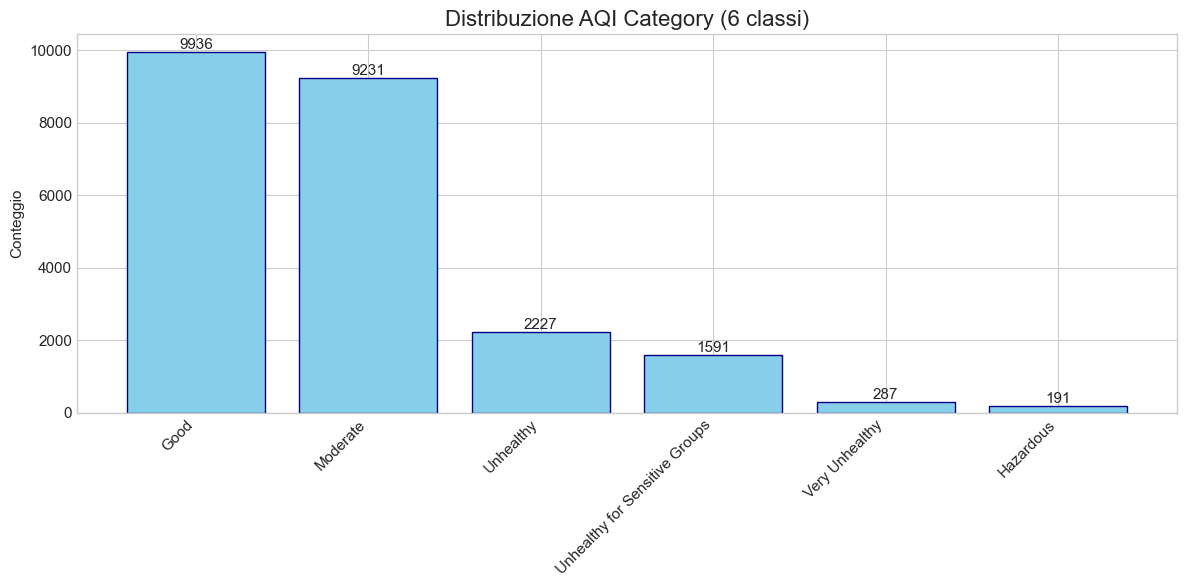

In [27]:
print("="*80)
print("ANALISI TARGET 6 CLASSI")
print("="*80)

target_dist = df['AQI Category'].value_counts()
target_pct = df['AQI Category'].value_counts(normalize=True) * 100

print("Conteggi:")
print(target_dist)
print("\nPercentuali:")
print(target_pct.round(2))

# Grafico
plt.figure(figsize=(12, 6))
bars = plt.bar(target_dist.index, target_dist.values, color='skyblue', edgecolor='navy')
plt.title('Distribuzione AQI Category (6 classi)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Conteggio')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')
plt.tight_layout()
plt.savefig(f'{output_dir}/01_target_distribution.jpg', dpi=300, bbox_inches='tight')
plt.show()


## 🔗 Analisi Correlazioni (Pearson + Spearman)

**Obiettivo:** Scoprire relazioni lineari (Pearson) e monotone (Spearman) tra inquinanti.


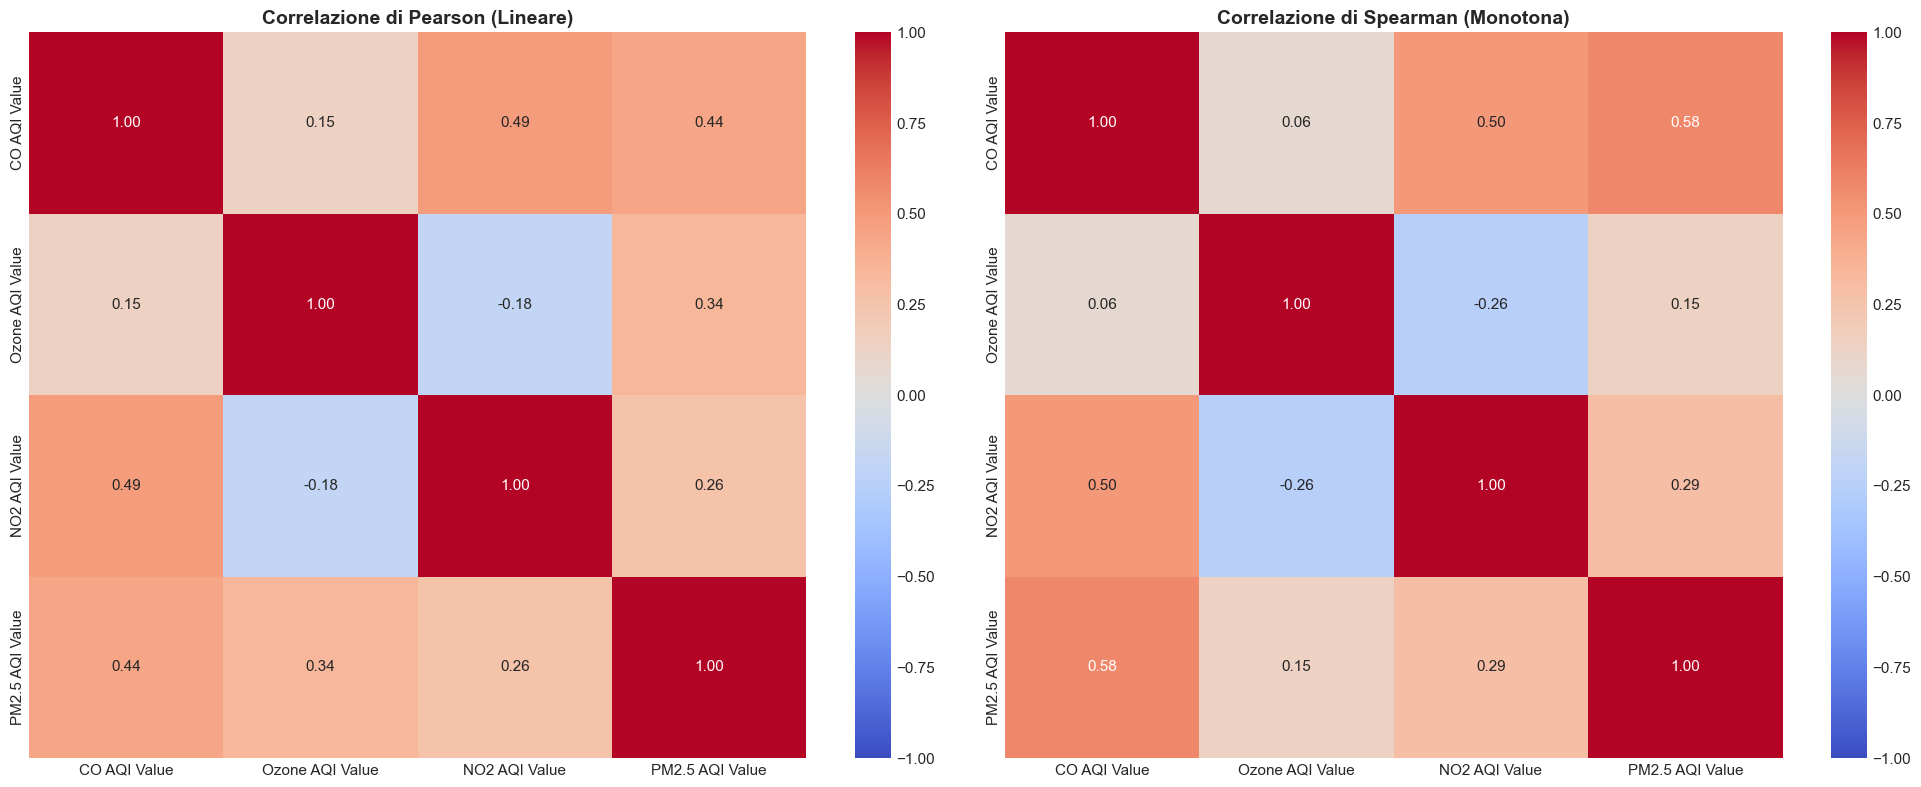

In [28]:
# Calcolo delle due matrici
corr_pearson = df[numeric_cols].corr(method='pearson')
corr_spearman = df[numeric_cols].corr(method='spearman')

# Plotting affiancato
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# 1. Pearson (Lineare)
sns.heatmap(corr_pearson, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, ax=axes[0])
axes[0].set_title('Correlazione di Pearson (Lineare)', fontsize=14, fontweight='bold')

# 2. Spearman (Monotona - Cattura relazioni non lineari)
sns.heatmap(corr_spearman, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, ax=axes[1])
axes[1].set_title('Correlazione di Spearman (Monotona)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{output_dir}/02_correlation_matrix_comparison.jpg', dpi=300)
plt.show()


ANALISI BIVARIATA: Relazioni a coppie e separabilità delle classi


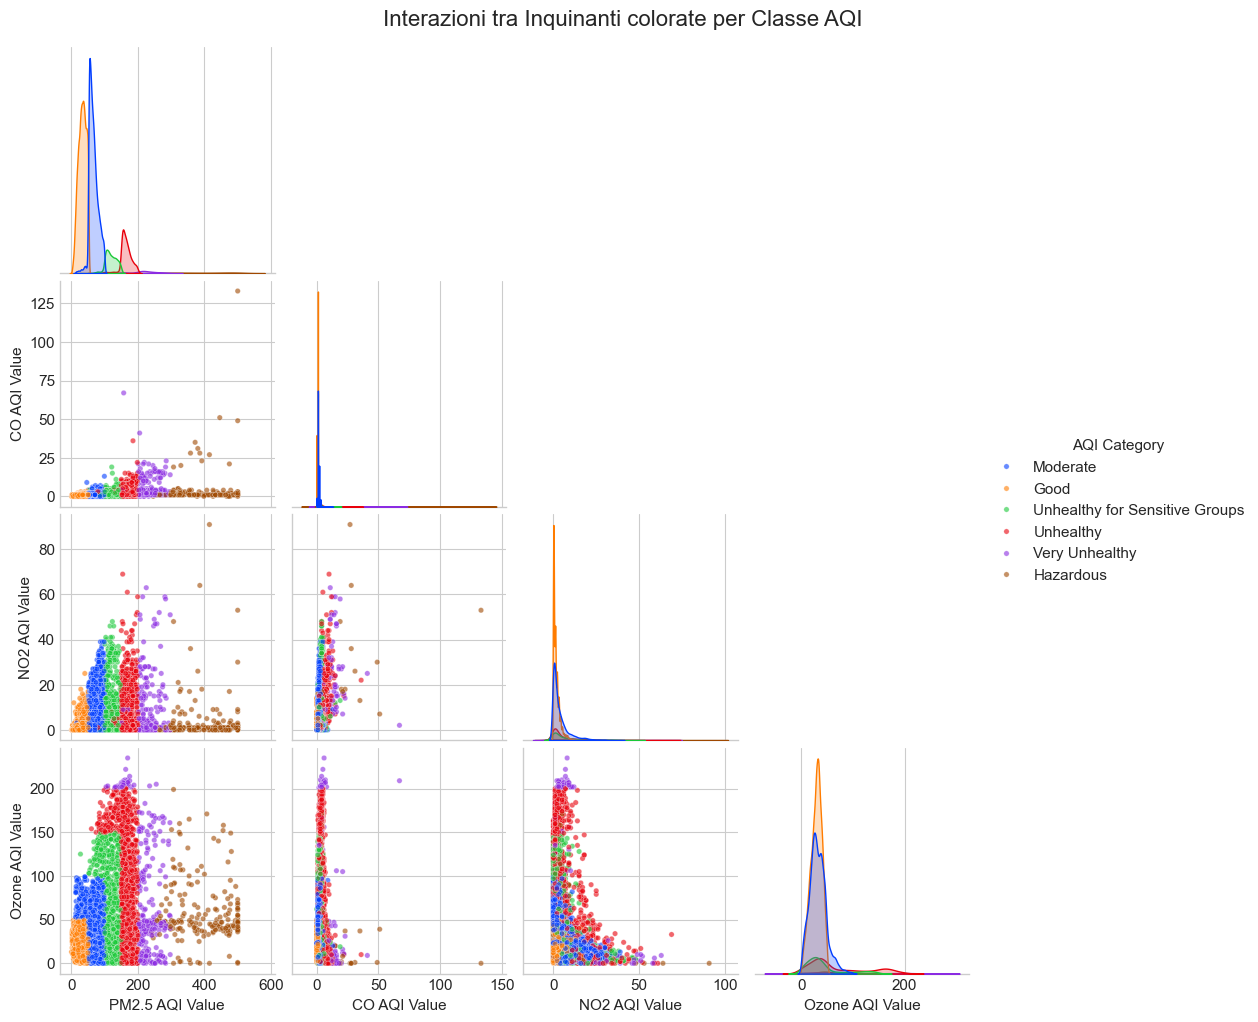

In [29]:
# Analisi Bivariata: Scatterplot Matrix (Pairplot)
# Selezioniamo solo le feature principali per non fare grafici illeggibili
cols_to_plot = ['PM2.5 AQI Value', 'CO AQI Value', 'NO2 AQI Value', 'Ozone AQI Value']

# Usiamo il target temporaneo a 3 classi per colorare
# (Assicurati di avere 'AQI_Category_3Class' nel df o ricrealo al volo)

print("="*80)
print("ANALISI BIVARIATA: Relazioni a coppie e separabilità delle classi")
print("="*80)

sns.pairplot(df,
             vars=cols_to_plot,
             hue='AQI Category', # O la versione a 3 classi se preferisci meno confusione
             palette='bright',
             corner=True, # Rimuove la parte duplicata sopra la diagonale
             plot_kws={'alpha': 0.6, 's': 15}) # Trasparenza per vedere le sovrapposizioni

plt.suptitle('Interazioni tra Inquinanti colorate per Classe AQI', y=1.02, fontsize=16)
plt.show()

# Interpretazione da scrivere:
# "Dal pairplot osserviamo che la classe 'Hazardous' (colore X) è trainata quasi esclusivamente
# dal PM2.5 (si trova tutto a destra sull'asse X del PM2.5).
# Le relazioni con gli altri gas mostrano frontiere meno nette, suggerendo..."



VERIFICA STRATEGIA: Pairplot con raggruppamento a 3 Classi


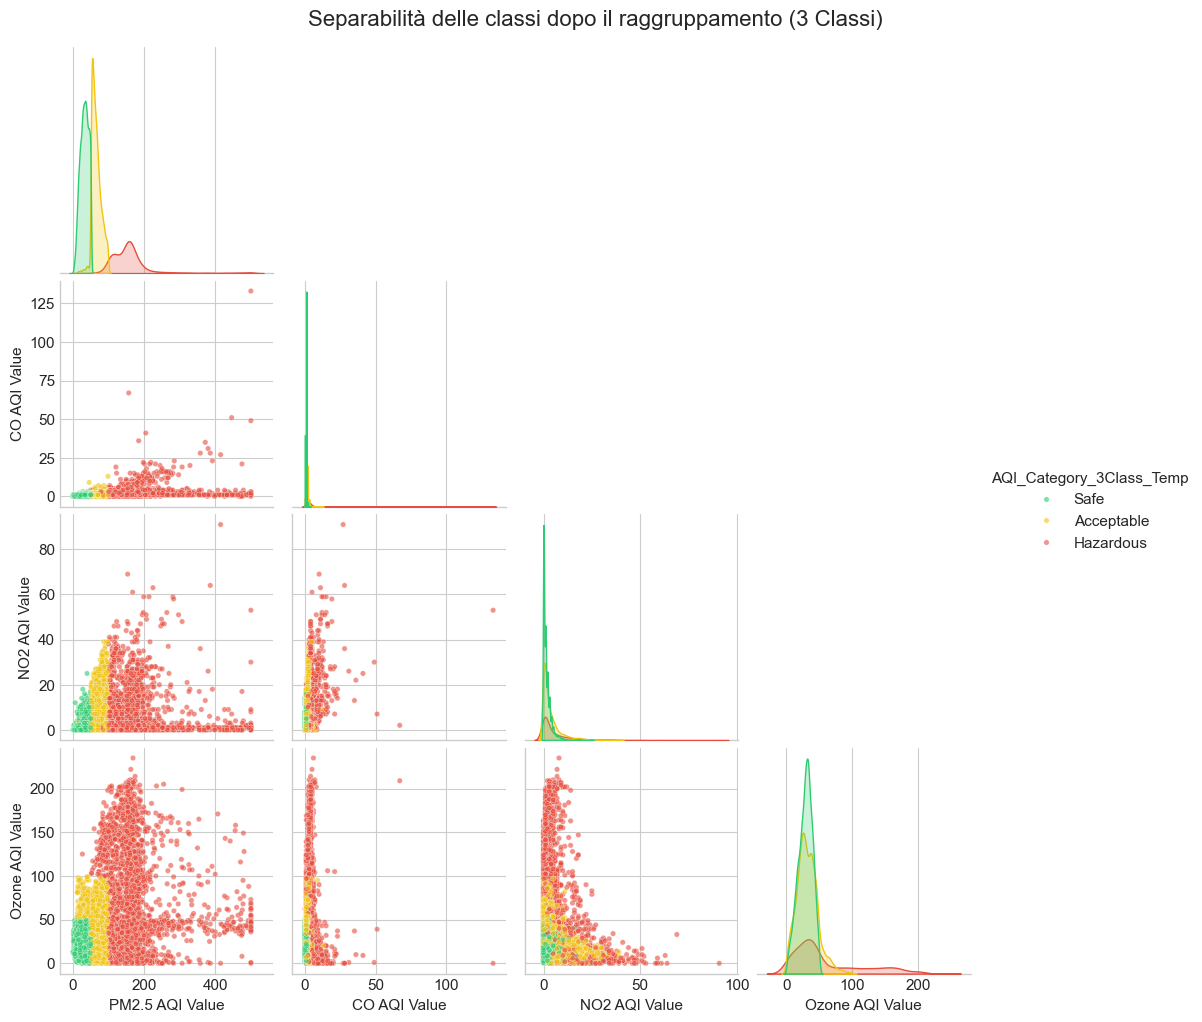

In [30]:
# --- CONFRONTO: Pairplot con Target a 3 Classi ---
# Creiamo una colonna temporanea solo per la visualizzazione
mapping_3_classes = {
    'Good': 'Safe',
    'Moderate': 'Acceptable',
    'Unhealthy for Sensitive Groups': 'Hazardous',
    'Unhealthy': 'Hazardous',
    'Very Unhealthy': 'Hazardous',
    'Hazardous': 'Hazardous'
}
df['AQI_Category_3Class_Temp'] = df['AQI Category'].map(mapping_3_classes)

# Ordine logico delle classi per la legenda (dal verde al rosso)
hue_order = ['Safe', 'Acceptable', 'Hazardous']
custom_palette = {'Safe': '#2ecc71', 'Acceptable': '#f1c40f', 'Hazardous': '#e74c3c'} # Verde, Giallo, Rosso

print("="*80)
print("VERIFICA STRATEGIA: Pairplot con raggruppamento a 3 Classi")
print("="*80)

sns.pairplot(df,
             vars=['PM2.5 AQI Value', 'CO AQI Value', 'NO2 AQI Value', 'Ozone AQI Value'],
             hue='AQI_Category_3Class_Temp',
             hue_order=hue_order,
             palette=custom_palette,
             corner=True,
             plot_kws={'alpha': 0.6, 's': 15})

plt.suptitle('Separabilità delle classi dopo il raggruppamento (3 Classi)', y=1.02, fontsize=16)
plt.show()

# Pulizia colonna temporanea
df.drop('AQI_Category_3Class_Temp', axis=1, inplace=True)

# Interpretazione da Markdown:
# "Come ipotizzato, il passaggio a 3 classi rende le zone di separazione molto più chiare.
# La classe 'Hazardous' (Rosso) è ora ben definita dai picchi di PM2.5 e CO, mentre 'Safe' e 'Acceptable'
# mostrano ancora una parziale sovrapposizione che il modello dovrà imparare a gestire."


## 📊 Distribuzioni Features per Classe Target (Violin Plots)

**Obiettivo:** Visualizzare la separabilità delle classi.
- Vogliamo vedere se le distribuzioni di "Safe", "Acceptable" e "Hazardous" sono ben distinte o sovrapposte.
- **Nota:** Qui includiamo `AQI Value` solo a scopo visuale per confermare la coerenza delle categorie, ma non sarà usato nel modello.


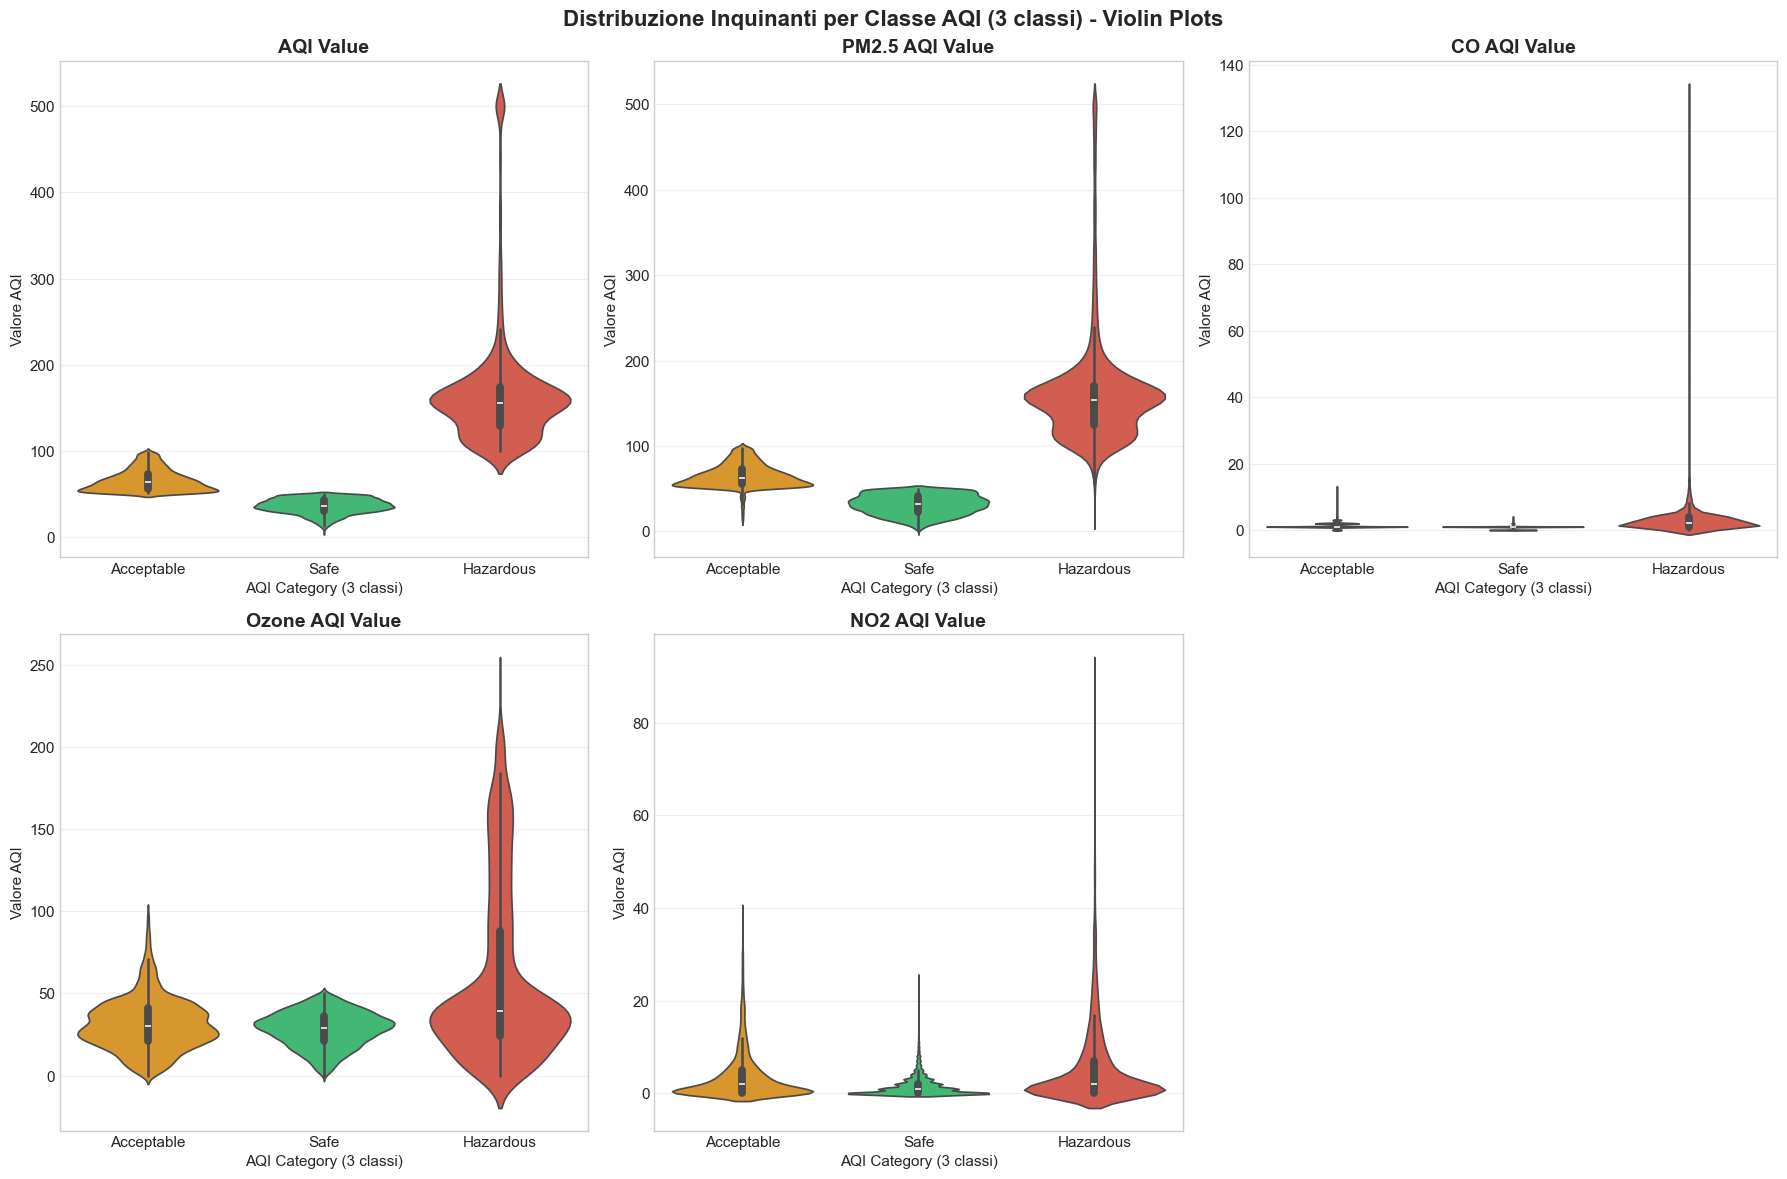

In [31]:
# VIOLIN PLOT DEFINITIVO - TUTTE LE 5 FEATURES INSIEME
# Creazione target temporaneo a 3 classi
mapping_3classes_tmp = {
    'Good': 'Safe',
    'Moderate': 'Acceptable',
    'Unhealthy for Sensitive Groups': 'Hazardous',
    'Unhealthy': 'Hazardous',
    'Very Unhealthy': 'Hazardous',
    'Hazardous': 'Hazardous'
}
df['AQI_Category_3Class_tmp'] = df['AQI Category'].map(mapping_3classes_tmp)

# 5 Violin plots in griglia 2x3
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

features_violin = ['AQI Value', 'PM2.5 AQI Value', 'CO AQI Value',
                   'Ozone AQI Value', 'NO2 AQI Value']
colors_palette = ['#2ecc71', '#f39c12', '#e74c3c']  # Safe, Acceptable, Hazardous

for i, feature in enumerate(features_violin):
    sns.violinplot(data=df, x='AQI_Category_3Class_tmp', y=feature,
                   ax=axes[i], hue='AQI_Category_3Class_tmp', legend=False,
                   palette={'Safe': colors_palette[0], 'Acceptable': colors_palette[1], 'Hazardous': colors_palette[2]})

    axes[i].set_title(f'{feature}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('AQI Category (3 classi)', fontsize=11)
    axes[i].set_ylabel('Valore AQI', fontsize=11)
    axes[i].grid(axis='y', alpha=0.3)

# Nascondere il 6° subplot vuoto
axes[-1].set_visible(False)

plt.suptitle('Distribuzione Inquinanti per Classe AQI (3 classi) - Violin Plots',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{output_dir}/04_feature_distributions_by_class.jpg', dpi=300, bbox_inches='tight')
plt.show()

df.drop('AQI_Category_3Class_tmp', axis=1, inplace=True)

## 🐛 Rilevamento Outlier (Boxplots)

Utilizziamo il metodo IQR per *identificare* i valori estremi, ma applicheremo una strategia conservativa:

**Decisione:** Non rimuoveremo gli outlier identificati in questa fase.

**Motivazione:** Nel monitoraggio ambientale, i valori estremi (picchi di inquinamento) rappresentano proprio la classe "Hazardous" che vogliamo predire. Rimuoverli significherebbe eliminare i segnali di allarme reali, rendendo il modello cieco ai casi più critici.




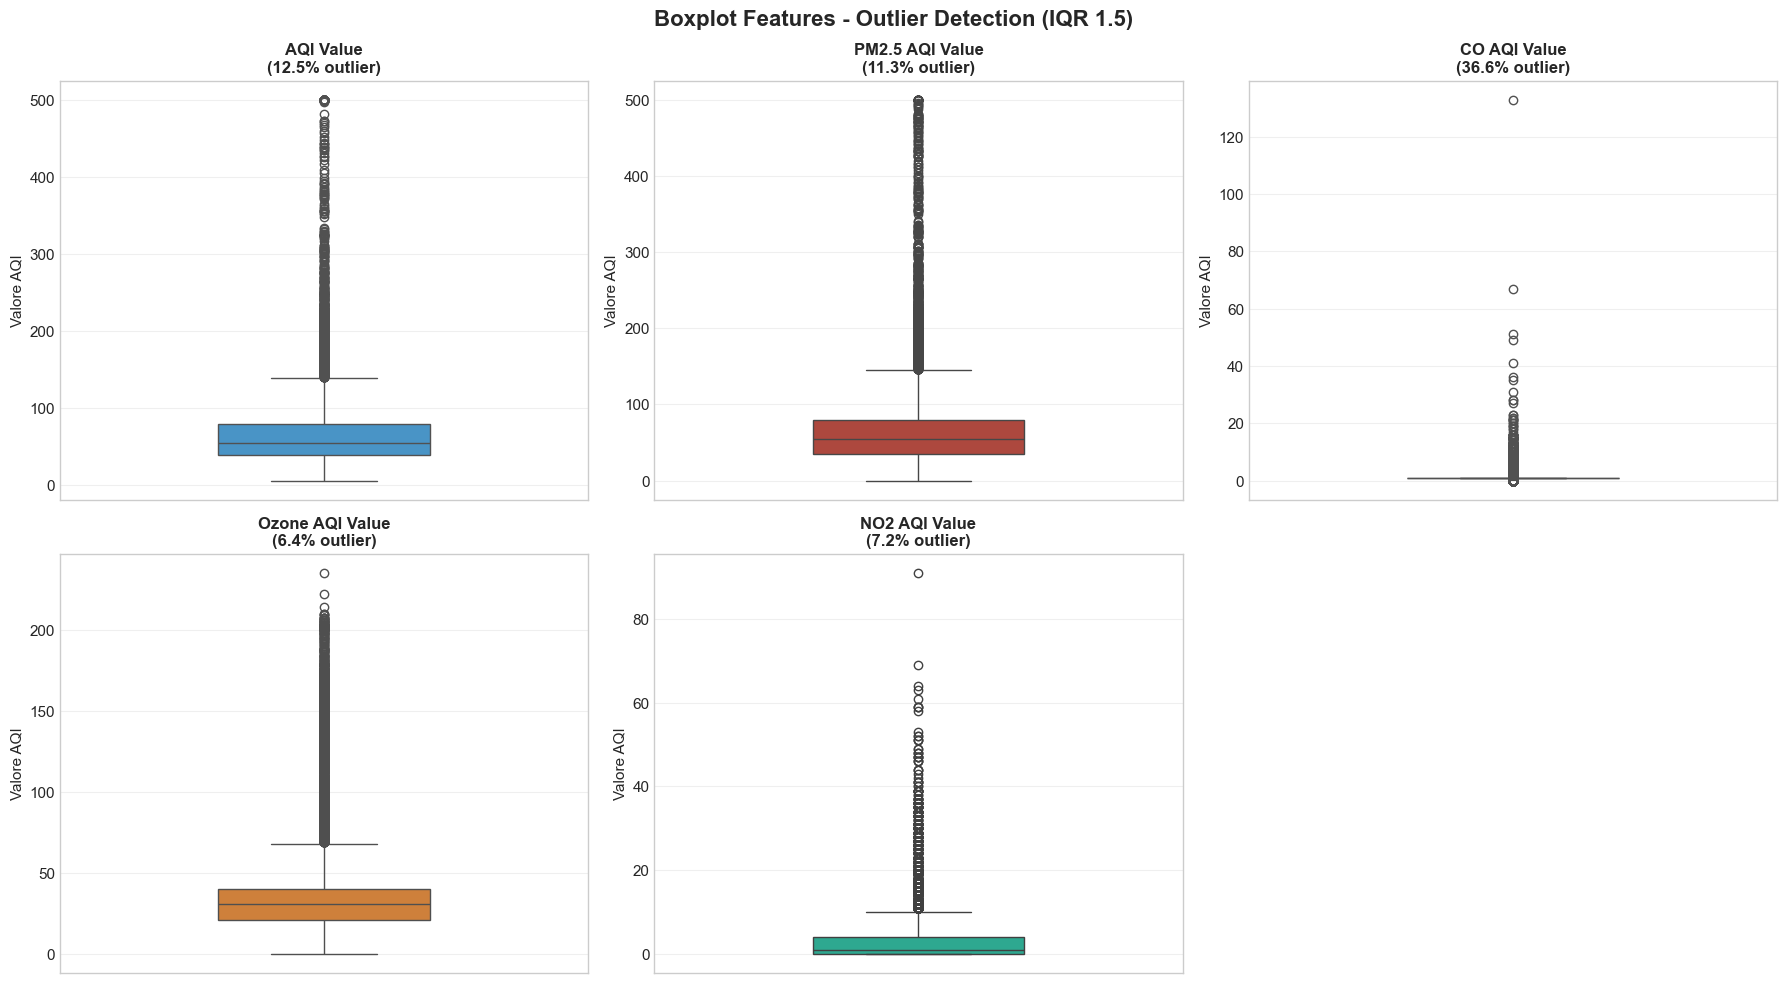

✅ Boxplot salvato - Tutte le 5 features visibili


In [32]:
# BOXPLOT DEFINITIVO - TUTTE LE 5 FEATURES INSIEME
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

numeric_cols_ordered = ['AQI Value', 'PM2.5 AQI Value', 'CO AQI Value',
                        'Ozone AQI Value', 'NO2 AQI Value']
colors_box = ['#3498db', '#c0392b', '#9b59b6', '#e67e22', '#1abc9c']
outliers_pct = [12.5, 11.3, 36.6, 6.4, 7.2]

for i, (col, color, pct) in enumerate(zip(numeric_cols_ordered, colors_box, outliers_pct)):
    sns.boxplot(y=df[col], ax=axes[i], color=color, width=0.4)
    axes[i].set_title(f'{col}\n({pct:.1f}% outlier)', fontweight='bold', fontsize=12)
    axes[i].grid(True, alpha=0.3, axis='y')
    axes[i].set_ylabel('Valore AQI', fontsize=11)

# Nascondere il 6° subplot vuoto
axes[-1].set_visible(False)

plt.suptitle('Boxplot Features - Outlier Detection (IQR 1.5)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{output_dir}/03_outliers_boxplots.jpg', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Boxplot salvato - Tutte le 5 features visibili")


## 🔮 Analisi Dimensionalità (PCA)

**Obiettivo:** Verificare se esiste ridondanza tra gli inquinanti.

**Perché:** Se due gas (es. CO e NO2) fossero correlati al 95%, potremmo fonderli in una sola variabile (Principal Component) riducendo il rumore.

**Grafico "Elbow":** Cerchiamo il punto in cui la varianza spiegata cumulativa raggiunge il 90-95%. Se servono tutte le componenti per arrivare al 90%, significa che ogni inquinante porta informazione unica e non possiamo semplificare.


ANALISI PCA (su features standardizzate)
Componenti Principali:
PC 1: 46.0% varianza (cumulativa: 46.0%)
PC 2: 30.8% varianza (cumulativa: 76.8%)
PC 3: 12.8% varianza (cumulativa: 89.5%)
PC 4: 10.5% varianza (cumulativa: 100.0%)
Features usate per PCA: ['CO AQI Value', 'Ozone AQI Value', 'NO2 AQI Value', 'PM2.5 AQI Value']


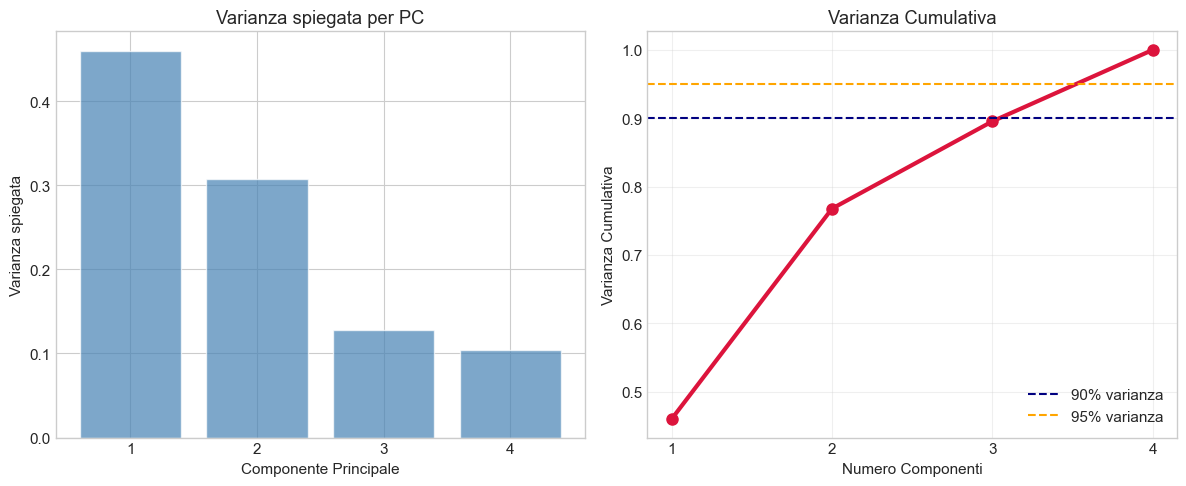


 CONCLUSIONE: Le prime 3 componenti spiegano il 89.5% della varianza.
DECISIONE: Manteniamo le features originali per preservare l'interpretabilità chimica del modello.


In [33]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Usiamo solo le feature fisiche (senza AQI Value)
features_for_pca = [c for c in numeric_cols if c != 'AQI Value']
X_pca = df[features_for_pca].fillna(0)

# Standardizzazione è OBBLIGATORIA per la PCA
# (altrimenti feature con scala 0-500 dominano su quelle 0-1)
scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

# PCA
pca = PCA()
pca_result = pca.fit_transform(X_pca_scaled)

print("="*80)
print("ANALISI PCA (su features standardizzate)")
print("="*80)

# Varianza spiegata
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)
n_components = len(features_for_pca)

print("Componenti Principali:")
for i, (var, cum) in enumerate(zip(explained_var, cumulative_var), 1):
    print(f"PC{i:2}: {var:.1%} varianza (cumulativa: {cum:.1%})")

# Grafico varianza cumulativa
plt.figure(figsize=(12, 5))

print(f"Features usate per PCA: {features_for_pca}")
# Deve stampare: ['CO AQI Value', 'Ozone AQI Value', 'NO2 AQI Value', 'PM2.5 AQI Value']


# Plot 1: Varianza per singola componente
plt.subplot(1, 2, 1)
# range dinamico basato sul numero reale di feature
x_range = range(1, n_components + 1)
plt.bar(x_range, explained_var, alpha=0.7, color='steelblue')
plt.title('Varianza spiegata per PC')
plt.xlabel('Componente Principale')
plt.ylabel('Varianza spiegata')
plt.xticks(x_range)

# Plot 2: Varianza Cumulativa
plt.subplot(1, 2, 2)
plt.plot(x_range, cumulative_var, marker='o', linewidth=3, markersize=8, color='crimson')
plt.axhline(y=0.90, color='navy', linestyle='--', label='90% varianza')
plt.axhline(y=0.95, color='orange', linestyle='--', label='95% varianza')
plt.title('Varianza Cumulativa')
plt.xlabel('Numero Componenti')
plt.ylabel('Varianza Cumulativa')
plt.xticks(x_range)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}/05_pca_variance.jpg', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n CONCLUSIONE: Le prime 3 componenti spiegano il {cumulative_var[2]:.1%} della varianza.")
print("DECISIONE: Manteniamo le features originali per preservare l'interpretabilità chimica del modello.")
